
# Time Multiplexing for Delay Network Input

The goal here is to compress multiple signal dimensions into 1 signal as input to a neural network.  




In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nengo
from numpy import sin,cos,pi

In [2]:
t_sig = .01 # Period of Input Signal Multiplexing, effectively the inverse of the sampling rate of each multiplexed signal

# First let's implement a simple time multiplexor:

   Divide the signal into time windows of length $\tau_{sig}$.  Given a window, split it evenly between the D dimensions of the input vector. So output is essentially the input vector dotted with a time-dependent unit vector:
  $ x(t) = e_{i(t)}$,
  
   where $i$ takes values $[1,...D]$ and switches values every $\frac{\tau_{sig}}{D}$ seconds.
 

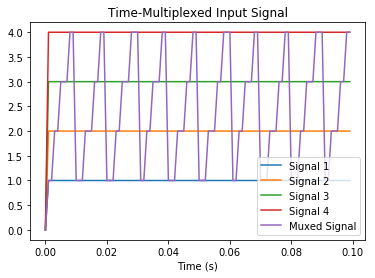

In [3]:
def chan_mux(t,u,t_sig=t_sig):
    u = np.asarray(u)
    D = u.size   # Number of Dimensions in Signal 

    # Decide which signal (i) will pass through, depending on the time
    for i in np.arange(D):
        if i*t_sig/D <= np.mod(t,t_sig) and np.mod(t,t_sig) < (i+1)*t_sig/D:
            idx = i
    # Quick way to make a unit vector
    e = np.zeros((D,1))
    e[idx] = 1
    return np.dot(np.squeeze(e),u)
################################################################################################################################
################################################################################################################################

#For Testing Mux Output: simulate a 4-channel Signal and pass it through the mux function
dt    = .001
T     = .1
N_samples = int(T/dt)

z = np.zeros((4,N_samples))
y = np.zeros((1,N_samples))

for idx in np.arange(1,N_samples):
    z[0,idx] = 1#  np.sin(.5*ts)
    z[1,idx] = 2#  .2*np.sin(.6*t)
    z[2,idx] = 3#  .3*np.sin(.8*t)
    z[3,idx] = 4#  .4*np.sin(1*t)
    
    y[0,idx] = chan_mux(dt*idx,z[:,idx],t_sig)
 
# Plotting
plt.plot(dt*np.arange(y.size),z[0,:],label='Signal 1')
plt.plot(dt*np.arange(y.size),z[1,:],label='Signal 2')
plt.plot(dt*np.arange(y.size),z[2,:],label='Signal 3')
plt.plot(dt*np.arange(y.size),z[3,:],label='Signal 4')
plt.plot(dt*np.arange(y.size),np.squeeze(y),label='Muxed Signal')
plt.title('Time-Multiplexed Input Signal')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


## Now Try it On Nengo-Generated Gaussian Noise

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

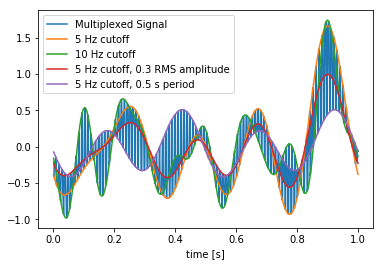

In [4]:
# Create 4 Channels of Gaussian White Noise
with nengo.Network() as model:
    a = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, seed=0))
    b = nengo.Node(nengo.processes.WhiteSignal(1.0, high=10, seed=0))
    c = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, rms=0.3, seed=0))
    d = nengo.Node(nengo.processes.WhiteSignal(0.5, high=5, seed=0))
    ap = nengo.Probe(a)
    bp = nengo.Probe(b)
    cp = nengo.Probe(c)
    dp = nengo.Probe(d)

# Run simulation to generate signals
with nengo.Simulator(model) as sim:
    sim.run(1.0)
    
# Now multiplex the signal: 

u = np.squeeze(np.asarray([
    sim.data[ap],
    sim.data[bp],
    sim.data[cp],
    sim.data[dp],
]))

u_mux = []
idx   = 0
for t in sim.trange():
    u_mux += [chan_mux(t,u[:,idx],t_sig)]
    idx += 1

plt.plot(sim.trange(),u_mux,label='Multiplexed Signal')
plt.plot(sim.trange(), u[0,:], label='5 Hz cutoff')
plt.plot(sim.trange(), u[1,:], label='10 Hz cutoff')
plt.plot(sim.trange(), u[2,:], label='5 Hz cutoff, 0.3 RMS amplitude')
plt.plot(sim.trange(), u[3,:], label='5 Hz cutoff, 0.5 s period')
plt.xlabel("time [s]")
plt.legend(loc=2)
plt.show()

#### Now we'll implement a sample & hold, randomly masked, multiplexed input to a nengo delay network.

###### We'll hardcode a muxer that only takes a time-argument. This makes it a time-driven process for interfacing with Nengo, as opposed to dealing with process inputs & outputs for a Nengo simulation.
###### To change the input signals, change the time-parametrized functions in the u vector of the simple_mux function.

# Signal Generation & Multiplex

### Generation looks like:
    1) Generate Signal, 
    2) Sample & Hold Signal over Time Period t_sig
    3) multiplex signal by splitting t_sig evenly between each channel and then passing the sampled value in order
    4) Repeat for next sample of input signal

In [5]:
############################################################
t_sig =.2# Choose the Time Mux Sample Rate
############################################################

# Input Process Generation for Nengo #######################################################################

def generate_input(t):
    # Generate the input vector u given only the time of the simulation
    u1 = np.sin(2*pi*t)
    u2 = np.cos(-pi*t)
    u3 = np.exp(-t)
    u4 = -.2
    
    return np.asarray([u1, u2, u3, u4])


def sample_and_hold(u,t,t_sig):
    # Receive a vector u at a single time t. If we are at an integer multiple of t_sig
    # pass through the present input and hold it.  Otherwise, only pass through the input at previously held input.
    assert u.size == 4, "The Input vector u should only be the input at one time step, but had size (%i)" %(u.size)
    
    counts_to_switch = t_sig/(.001)
    if 'count' not in sample_and_hold.__dict__:
        sample_and_hold.count = 0
        
    if 'past_input' not in sample_and_hold.__dict__:
        sample_and_hold.past_input = [0,0,0,0]
    
    if  sample_and_hold.count == counts_to_switch:
        sample_and_hold.past_input =[u[0],u[1],u[2],u[3]]
        sample_and_hold.count = 0
        
    sample_and_hold.count = sample_and_hold.count + 1
    try:
        return np.asarray(sample_and_hold.past_input)
    except UnboundLocalError:
        print('The past_input is not defined, and the current time is %f' %t)
        
    
def random_mask(u,seed):
    # Random mixing of input components, explore as possibility of adding nonlinear mixture into signal. 
    # Not currently in use. 
    # Receive a vector u at a single time t. Return a vector of the randomly mixed components of u
    assert u.size == 4, "The Input vector u should only be the input at one time step, but had size (%i)" %(u.size)
    
    if 'rand_matrix' not in random_mask.__dict__:
        np.random.seed(seed)
        random_mask.rand_matrix = np.random.rand(u.size,u.size)
        
    return np.dot(random_mask.rand_matrix,u)
    
  
def four_chan_mux(u,t,t_sig):
    D = u.size   # Number of Dimensions in Signal

    count_to_switch = t_sig/(4*.001)
    
    if np.mod(count_to_switch,1) != 0:
        print( 'Warning, Channels not evenly divided into multiplexed period:',count_to_switch)
    if 'count' not in four_chan_mux.__dict__:
        four_chan_mux.count = 0
    
    if 'chan_switch' not in four_chan_mux.__dict__:
        four_chan_mux.chan_switch = 0
    

    
    if four_chan_mux.count == count_to_switch:
        four_chan_mux.chan_switch = four_chan_mux.chan_switch + 1
        four_chan_mux.count = 0
        
    # Increment counter. 
    four_chan_mux.count = four_chan_mux.count + 1       
    
    if four_chan_mux.chan_switch == 4:
        four_chan_mux.chan_switch = 0
    return u[four_chan_mux.chan_switch]



def create_input_signal(t):
    # High-level function that generates and multiplexes a 4-channel signal
    u =  np.asarray(generate_input(t))    
    output = sample_and_hold(u[:],t,t_sig)
    #output = random_mask(output,seed=1)
    muxed  = four_chan_mux(output[:],t,t_sig)
    return muxed

# Now let's turn this simple mux into a process

class Mux(nengo.Process):
    # Constructs a process that implements signal generation. The process construct is used to interface with nengo.
    def make_step(self, shape_in, shape_out, dt, rng):
        
        state = np.array([0.0])

        # define the step function, which will be called
        # by the node every time step
        def step(t):
            state[:] =  create_input_signal(t)
            return state

        return step  # return the step function
############################################################################################################################

## Let's make some plots to see what's going on ############################################################################
## This first figure, lets look over 1 hold period, t_sig: Samples from all channels are
## held constant and the mux switches between each channel once over the hold period. 
reset()

output = np.zeros((4,10000))
u      = np.zeros((4,10000))
muxed =  np.zeros((10000,1))
for idx in np.arange(10000):
    u[:,idx] = generate_input(.001*idx)
    output[:,idx] = sample_and_hold(u[:,idx],idx*.001,t_sig)
    muxed[idx]    = four_chan_mux(output[:,idx],idx*.001,t_sig)
  
ts = np.arange(10000)*.001
xlims = [2*t_sig, 6*t_sig]

print(sample_and_hold.count)
plt.figure(0)
plt.plot(ts,output[0],label='Sample & Held Channel 1')
plt.plot(ts,output[1],label='Sample & Held Channel 2')
plt.plot(ts,output[2],label='Sample & Held Channel 3')
plt.plot(ts,output[3],label='Sample & Held Channel 4')
plt.scatter(ts,muxed,label='Multiplexed Signal')
plt.xlim(xlims)
plt.title('Multiplexed Output over 4 Sample and Hold Periods:')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('muxedOutput.png',bbox_inches='tight')
plt.show()


NameError: name 'reset' is not defined

In [ ]:
xlims = [0, 3]



for i in np.arange(4):
    plt.figure(i)
    plt.title("Channel %i Multiplexing Into Signal" % (i+1))
    plt.plot(ts,muxed,label='Multiplexed Channel')
    plt.plot(ts,output[i],color='r',label='Sample & Hold Channel %i'%(i+1))
    plt.plot(ts,u[i],'--',color='r',label='Input Channel %i' %i)
    
    plt.xlim([t_sig,3])
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    string = 'chan%ioutput' %i
    plt.savefig(string,bbox_inches='tight')

plt.show()



# Signal Recovery & Demultiplex

In [7]:
def demux(input_sig,t_sig):
    # Receive a vector u at a single time t. If we are at an integer multiple of t_sig
    # pass through the present input and hold it.  Otherwise, only pass through the input at previously held input.
    assert input_sig.size == 1, "The Input vector u should only be the output at one time step, but had size (%i)" %(u.size)
    
    count_to_switch = int(t_sig/(4*.001))
    if 'count' not in demux.__dict__:
        demux.count = 0
        
    # Initially Fill Channel 0
    if 'past_output' not in demux.__dict__:
        demux.past_output = [0,0,0,0]
    
    if 'next_output' not in demux.__dict__:
        demux.next_output = [0,0,0,0]
    
    
    if 'chan_switch' not in demux.__dict__:
        demux.chan_switch = 0
        
    if 'curr_chan_filled' not in demux.__dict__:
        demux.curr_chan_filled = False
        
        
    if not demux.curr_chan_filled:
        demux.next_output[demux.chan_switch] = input_sig
        demux.curr_chan_filled = True
        
    # Count to [count_to_switch]
    if int(demux.count) == int(count_to_switch):
        #If we reach the count, switch channels
        demux.chan_switch = demux.chan_switch + 1
        demux.curr_chan_filled = False
        demux.count = 0  
        
        if demux.chan_switch == 4:  # If we've reached all 4 channels, then change past output, repeat
            demux.chan_switch = 0
            chan1 = demux.next_output[0]
            chan2 = demux.next_output[1]
            chan3 = demux.next_output[2]
            chan4 = demux.next_output[3]
            demux.past_output = [chan1,chan2,chan3,chan4]
        
    # Increment counter. 
    demux.count = demux.count + 1   
    
    return demux.past_output

    
        
def sine_gen(t):
    if 'time' not in sine_gen.__dict__:
        sine_gen.time = .001
    sine_gen.time = sine_gen.time + .001
    return demux(np.sin(2*pi*sine_gen.time),sine_gen.time,t_sig)


def cos_gen(t):
    if 'time' not in sine_gen.__dict__:
        cos_gen.time = .001
    cos_gen.time = sine_gen.time + .001
    return demux(np.cos(-pi*cos_gen.time),cos_gen.time,t_sig)


def reset():
    sine_gen.time = 0
    cos_gen.time = 0
    sample_and_hold.past_input = [0,0,0,0]
    sample_and_hold.count = 0
    four_chan_mux.count = 0
    four_chan_mux.chan_switch = 0
    demux.chan_switch = 0
    demux.past_output = [0,0,0,0]
    demux.count = 0
   

In [ ]:
ts = np.arange(10000)*.001


reset()


demuxed = np.zeros((4,10000))

for idx in np.arange(10000):
    demuxed[:,idx] = demux(muxed[idx],t_sig)

for i in np.arange(4):
    plt.figure(i)
    plt.title("Channel %i Recovery From Signal" % (i+1))
    plt.plot(ts,demuxed[i],label='Demultiplexed Channel %i'%(i+1))
    plt.plot(ts,output[i],label='Input Channel %i'%(i+1))
    plt.xlim([0,3])
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    string = 'chan%idemuxed' %i
    plt.savefig(string,bbox_inches='tight')
    


plt.show()

In [13]:
from nengolib.networks import RollingWindow, t_default
from nengolib import Network
from nengolib.signal import Hankel


    
with Network() as model:
    reset()
    
    # Setup Rolling Window Network, delay theta = t_sig
    process = Mux()
    rw = RollingWindow(theta=t_sig, n_neurons=512, process=process,dimensions=18,neuron_type=nengo.LIFRate())  # Small T_sig means small window of delay 

    #Setup Inputs from Mux Channel to Delay Network
    mux_input = nengo.Node(process, size_in=0, size_out=1)
    impulse_input = nengo.Node(nengo.processes.Piecewise({0: 1, 0.1: 0}))
    #Connect Input to Network
    nengo.Connection(impulse_input, rw.input)
    #nengo.Connection(mux_input,rw.input)
    nengo.Connection(rw.add_output(t=1,function=lambda w:w),rw.input)
    
    # Probe & Decode Output
    rwp   = nengo.Probe(rw.add_output(t=0,function=lambda w: w),synapse = None)
    ip    = nengo.Probe(impulse_input)
#     delay = nengo.Probe(rw.add_output(t=1,function=lambda w: w**2),synapse = None)
#     mult  = nengo.Probe(rw.add_output(t=[1,3/4], function = lambda w: w[0]*w[1]),synapse =.1)
#     muxp = nengo.Probe(mux_input)
    
with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1549: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
c:\users\fritz\documents\github\nengolib\nengolib\signal\system.py:718: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

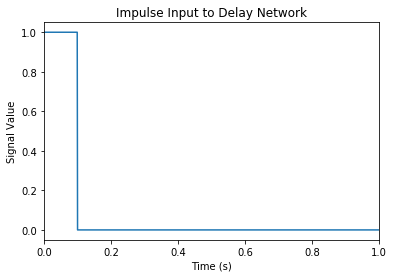

In [22]:
ts = sim.trange()
plt.plot(ts,sim.data[ip])
plt.xlim([0, 1])
plt.title('Impulse Input to Delay Network')
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.savefig('impulseInput.png')

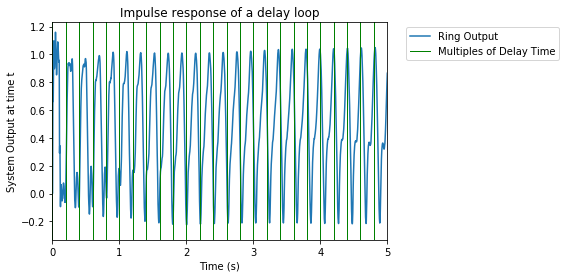

In [47]:
ts = sim.trange()
plt.xlim([0,5])
plt.xlabel("Time (s)")
plt.ylabel('System Output at time t')
plt.title('Impulse response of a delay loop')
plt.plot(ts,sim.data[rwp],label='Ring Output')
taus = np.arange(30)*t_sig
for xc in taus:
    plt.axvline(x=xc,LineWidth=1,color='g')

plt.legend(['Ring Output','Multiples of Delay Time'],bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig('ImpulseResponse.png',dpi=1200,bbox_inches='tight')


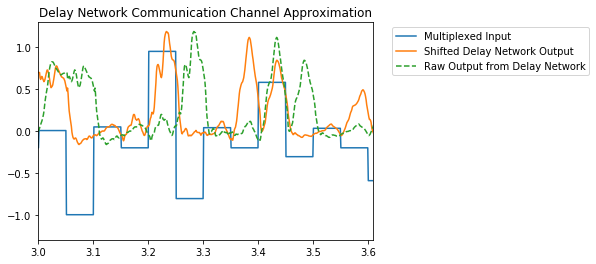

In [31]:
ts = sim.trange()

xlims = [3, 3+3*t_sig+.01]
ylims = [-1.3, 1.3]

bad_output     = sim.data[delay]
delayed_output = np.roll(sim.data[delay],-int((.25*t_sig)/.001))

plt.title('Delay Network Communication Channel Approximation')
plt.plot(ts,sim.data[muxp],label='Multiplexed Input')
plt.plot(ts,delayed_output,label='Shifted Delay Network Output')
plt.plot(ts,bad_output,'--',label='Raw Output from Delay Network')
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
string = 'delayedcommChanApprox'
plt.savefig(string,bbox_inches='tight')


plt.show()

In [32]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider





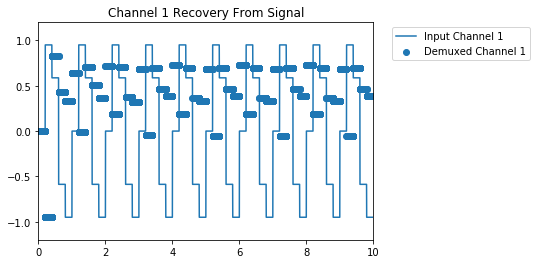

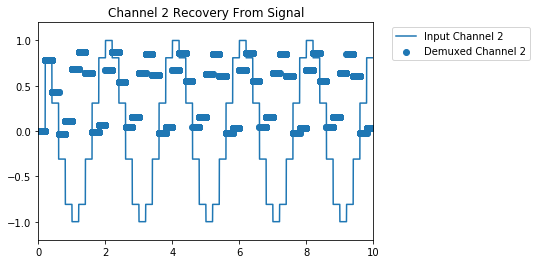

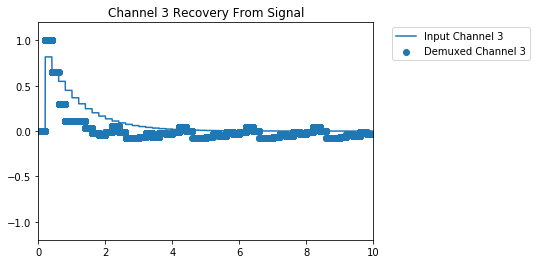

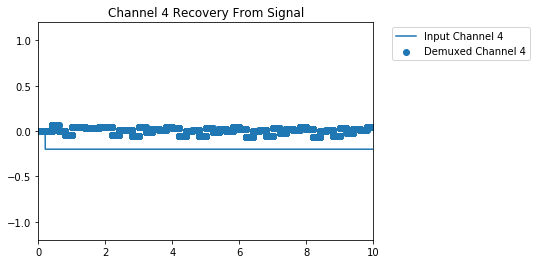

In [33]:
def plotstuff(x):
    delayed_output = np.roll(sim.data[delay],-int((x*t_sig)/.001))

    recovered = np.zeros((4,10000))

    for idx in np.arange(10000):
        recovered[:,idx] = demux(delayed_output[idx],t_sig)
    
    for i in np.arange(4):
        plt.figure(i)
        plt.title("Channel %i Recovery From Signal" % (i+1))
        plt.scatter(ts,recovered[i],label='Demuxed Channel %i'%(i+1))
        plt.plot(ts,output[i],label='Input Channel %i'%(i+1))
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.xlim([0,10])
        plt.ylim([-1.2,1.2])
        string = 'comm%irecovered' %i
        plt.savefig(string,bbox_inches='tight')
        
    
    plt.show()




plotstuff(1.21)
#plotstuff(1.22)

In [34]:
# Lets see if we can recover the product of two channels from the multiplexed input:

def sing_chan_sample_hold(x,t_sig):
    count_to_switch = t_sig/.001
    # Sample a signal x and hold the value for a time t_sig
    if 'count' not in sing_chan_sample_hold.__dict__:
        sing_chan_sample_hold.count = 0
        
    if 'output' not in sing_chan_sample_hold.__dict__:
        sing_chan_sample_hold.output = x
        
    
    sing_chan_sample_hold.count = sing_chan_sample_hold.count + 1
    
    if sing_chan_sample_hold.count == count_to_switch:
        sing_chan_sample_hold.count = 0
        sing_chan_sample_hold.output = x
    
    return sing_chan_sample_hold.output
        
    


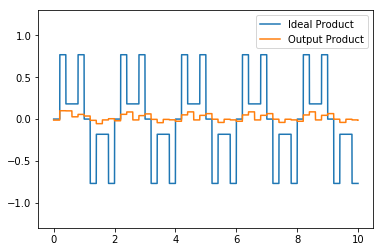

In [35]:
reset()
delayed_mult = np.roll(sim.data[mult],-int((.5*t_sig)/.001))

held_mult = np.zeros((delayed_mult.size,1))

for idx in np.arange(ts.size):
    held_mult[idx]  = sing_chan_sample_hold(delayed_mult[idx],t_sig)
    



    
plt.plot(ts,output[0]*output[1],label='Ideal Product')
plt.plot(ts,held_mult,label='Output Product')
#plt.plot(ts,delayed_mult)
plt.legend()
#plt.xlim([5,10])
plt.ylim([-1.3,1.3])
plt.show()

In [ ]:
t1 = np.arange(-2,2)